# Introducción a la inferencia estadística
#IE09 Caso Práctico - Desafío para los Inversores


## <font color='blue'>**Un ejemplo práctico**</font>

### 1. El desafío para los inversores

Un desafío común al que se enfrenta un inversor es determinar si es probable que una acción cumpla con sus objetivos de inversión. Por ejemplo, considere a Loki, que busca invertir en acciones seguras durante los próximos cinco años.

Al ser un inversor reacio al riesgo, solo se sentiría cómodo invirtiendo en una acción si ésta le brinda retornos mensuales preferiblemente no negativos en promedio y si puede estar razonablemente seguro de que su retorno mensual promedio no será inferior al -0,5%.

Loki está muy interesado en las acciones de ITC (NSE: ITC), pero quiere asegurarse de que cumpla con su criterio. En tal caso, ¿existe algún marco teórico / estadístico que pueda ayudarla a llegar a una conclusión sobre el rendimiento mensual promedio de las acciones de ITC con cierta confianza?

¡La respuesta es sí! Y dicho marco estadístico se basa en el supuesto de la distribución de rendimiento, que a su vez se basa en el Teorema del límite central (CLT).

### 2. El supuesto de normalidad en las finanzas

En los modelos financieros, generalmente asumimos que la serie de precios tiene una distribución logarítmica normal y, por lo tanto, los rendimientos se distribuyen normalmente. Y así, para los inversores, que utilizan estos modelos para invertir, mucho depende de si el supuesto de normalidad se cumple o no en los mercados.

Echemos un vistazo a las acciones de ITC (NSE: ITC) en las que Loki está interesado. Para realizar el análisis, primero importamos algunas bibliotecas estándar de Python y obtenemos los datos de acciones de ITC de Close-Close diarios de la biblioteca de finanzas.

In [ ]:
!pip install yfinance
!pip install pyfolio

     |████████████████████████████████| 63 kB 878 kB/s 
     |████████████████████████████████| 6.4 MB 11.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 91 kB 3.7 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88682 sha256=21ba9c4e696cbcf

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
# Librerias necesarias
import datetime as dt
import yfinance as yf
import pyfolio as pf
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', None)

# Obtención de los datos de acciones del ITC de la biblioteca yfinance de los últimos 10 años
start = dt.datetime(2010,1,1).date()
end = dt.datetime(2020,12,31).date()
ITC = yf.download('ITC.NS',start, end)[['Adj Close']]

daily_data = ITC.copy().round(4)

# Cálculo de retornos diarios
daily_data['daily_return']= np.log(daily_data['Adj Close']/daily_data['Adj Close'].shift())
daily_data.dropna(inplace=True)

# Echando un vistazo a los datos obtenidos
daily_data.head()

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


[*********************100%***********************]  1 of 1 completed


,Adj Close,daily_return
Date,,
2010-01-05,65.9113,0.009808
2010-01-06,66.0657,0.002340
2010-01-07,65.8598,-0.003121
2010-01-08,66.0013,0.002146
2010-01-11,66.0270,0.000389


Ahora que tenemos las retornos diarios de ITC (en escala logarítmica), en los siguientes diagramas visualizamos tanto los retornos como su distribución:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


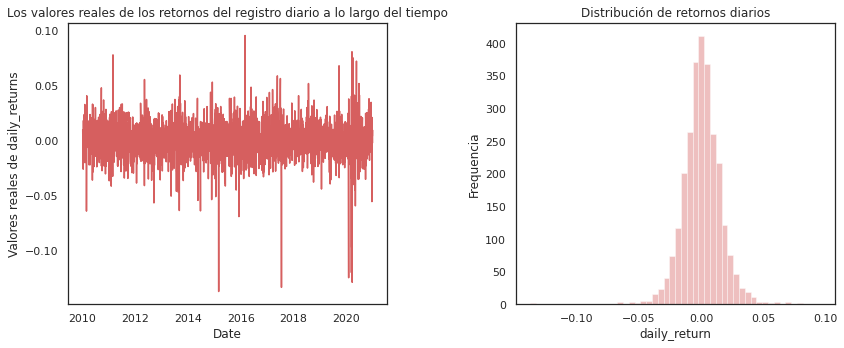

In [ ]:
import matplotlib.pyplot as plt

# Visualización de los retornos del registro diario
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
# Trace un histograma simple con el tamaño del bins determinado automáticamente
sns.lineplot(daily_data.index,daily_data['daily_return'], color="r")
plt.ylabel('Valores reales de daily_returns')
plt.title('Los valores reales de los retornos del registro diario a lo largo del tiempo')

plt.subplot(1,2,2)

sns.distplot(daily_data['daily_return'], kde=False, color="r")
plt.ylabel('Frequencia')


plt.tight_layout()
plt.title('Distribución de retornos diarios')

plt.show();

Podemos observar que en los diez años que estamos usando, el rendimiento diario de ITC se centra en 0. Sin embargo, ha habido múltiples ocasiones en las que ha superado la marca del cinco por ciento al alza e incluso una marca negativa del diez por ciento a la baja.

Esto es lo que es responsable de la mayor **curtosis**  que no es el caso de una distribución normal. 

Sin embargo, nuestras conclusiones se basan en el análisis visual hasta ahora. Para validarlos, necesitamos realizar una prueba estadística adecuada para verificar la normalidad/no normalidad de los datos, que es lo que hacemos en la siguiente sección.

### 3. La prueba de Shapiro-Wilk
Podemos realizar una prueba estadística, la prueba de Shapiro-Wilk, para verificar la normalidad de los datos. Es la prueba más poderosa cuando se prueba una distribución normal.

Si el valor p es mayor que 0.01, y asumimos una distribución normal con 99% de confianza, de lo contrario rechazamos la hipótesis nula de normalidad.

Ejecutamos la prueba mencionada anteriormente a continuación en los retornos de registro diarios usando la función shapiro de la biblioteca scipy:

In [ ]:
from scipy.stats import shapiro
stat1, p1 = shapiro(daily_data['daily_return'])

if p1 < 0.01:
    test_result1 = 'No es Normal'
    print(f' Si el p-value es {p1}, por lo tanto se rechaza que los datos se distribuyen normnalmente con un 99% de confianza.')
else:
    test_result1 = 'NORMAL'
    print(f'El p-value es {p1}, poir lo tanto asumimos que los datos estan distribuidos normalmente con un 99% de confianza. ')

 Si el p-value es 5.309610981421456e-35, por lo tanto se rechaza que los datos se distribuyen normnalmente con un 99% de confianza.


### 4. El papel del teorema del límite central

Recuerde que CLT supone  que X es una variable aleatoria (no necesariamente normal) que representa los datos de la población. Y que la distribución de
X, tiene una media de μ  y desviación estándar σ. Supongamos que estamos tomando muestras repetidas de tamaño _n_ de la población anterior. Entonces, para un tamaño de muestra _n_ suficientemente alto, las siguientes propiedades son verdaderas:

1. $$ \bar{x}\rightarrow \mathcal{N}(\mu,\frac{\sigma}{\sqrt{n}})$$

2. Pero $$\bar{x} = \frac{x_1+x_2+..+x_n}{n}$$

3. Entonces $$\frac{x_1+x_2+..+x_n}{n} \rightarrow \mathcal{N}(\mu,\frac{\sigma}{\sqrt{n}})$$

4. Por lo tanto $$ [x_1+x_2+..+x_n] \rightarrow \mathcal{N}(n\mu,\sigma\sqrt{n})$$

Por lo tanto, hemos demostrado que de acuerdo con el teorema del límite central, si $[x_1,x_2+..,x_n]$   es una muestra aleatoria de tamaño _n_ de una población de cualquier distribución, entonces la suma $[x_1+x_2+..+x_n]$ es tambien distribuida normalmente, dado un _n_ grande. 

En nuestro caso, las muestras aleatorias repetidas no son más que rendimientos logarítmicos diarios consecutivos de la acción. Como los retornos de registros son de naturaleza aditiva, si tomamos muestras de los retornos de registros diarios para cada día de la semana (asumiendo que hay cinco días de negociación en la semana) y los sumamos, obtenemos el rendimiento semanal.

Del mismo modo, si sumamos los rendimientos del registro diario de todos los días de negociación en un mes, obtenemos el rendimiento mensual.

### 5. Prueba de la normalidad de las devoluciones semanales y mensuales

Uno de los aspectos principales al construir modelos financieros cuantitativos basados en los rendimientos de las acciones es que existe un proceso de generación de datos de población,  y estamos tomando muestras de esos datos.

Por ejemplo, asumimos que existe un proceso de generación de datos que genera retornos de acciones. Se desconocen los parámetros que definen la distribución de este proceso, pero es necesario estimarlos.

Si usamos retornos de registros diarios, estamos muestreando los datos al final de cada día de negociación del precio de cierre anterior. Por lo tanto, $x_1$
es el rendimiento del registro al final del primer día de negociación,
$x_2$ es el retorno del registro al final del segundo día de negociación y así sucesivamente. Ahora bien, si tomamos una muestra de _n_ días, tenemos una muestra de tamaño _n_. Ya hemos visto que las devoluciones de los registros diarios no se distribuyen normalmente.

Veamos qué sucede cuando analizamos los rendimientos semanales en lugar de los rendimientos diarios (es decir, aumentamos _n_ de 1 a 5).



In [ ]:
# Remuestreo para obtener datos de cierre-cierre semanal y retorno semanal
weekly_data = ITC.resample('W').last()
weekly_data['weekly_return'] = np.log(weekly_data['Adj Close'] / weekly_data['Adj Close'].shift())
weekly_data.dropna(inplace=True)
weekly_data.head()

,Adj Close,weekly_return
Date,,
2010-01-17,65.036392,-0.014728
2010-01-24,64.097183,-0.014547
2010-01-31,64.367348,0.004206
2010-02-07,63.904194,-0.007221
2010-02-14,63.595417,-0.004844


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


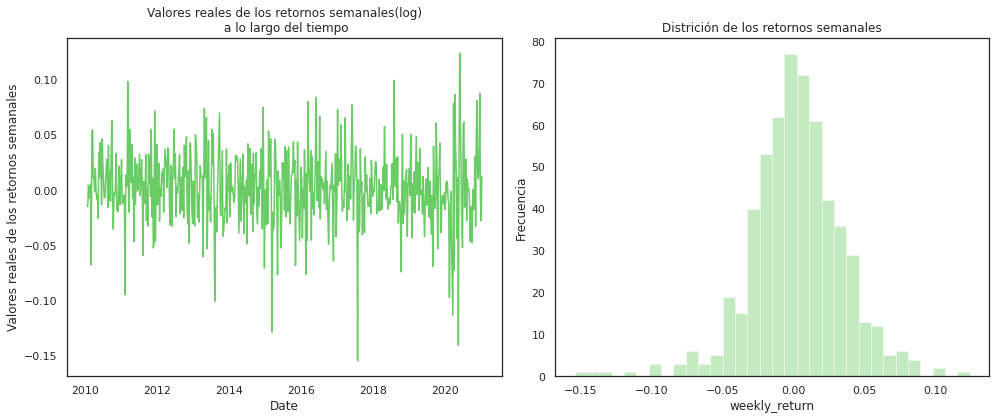

In [ ]:
# Dibujando el valor actual y la distribucion de retornos semanales. 
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.lineplot(weekly_data.index,weekly_data['weekly_return'], color="g")
plt.ylabel('Valores reales de los retornos semanales')
plt.title('Valores reales de los retornos semanales(log)\n a lo largo del tiempo')

plt.subplot(1,2,2)
sns.distplot(weekly_data['weekly_return'], kde=False, color="g")
plt.ylabel('Frecuencia')
plt.title('Districión de los retornos semanales')

plt.tight_layout()
plt.show();

In [ ]:
from scipy.stats import shapiro
stat2, p2 = shapiro(weekly_data['weekly_return'])

if p2 < 0.01:
    test_result1 = 'No es Normal'
    print(f' Si el p-value es {p2}, por lo tanto se rechaza que los datos se distribuyen normnalmente con un 99% de confianza.')
else:
    test_result1 = 'NORMAL'
    print(f'El p-value es {p2}, poir lo tanto asumimos que los datos estan distribuidos normalmente con un 99% de confianza. ')

 Si el p-value es 6.170883359857271e-09, por lo tanto se rechaza que los datos se distribuyen normnalmente con un 99% de confianza.


Un valor p pequeño indica que, incluso cuando tomamos muestras a nivel semanal, los datos no son normales. 

## <font color='green'>**Actividad 1**</font>
Verifique si los rendimientos mensuales (es decir, aumentando el tamaño de la muestra a 20) se distribuyen normalmente.

In [ ]:
# Remuestreo para obtener datos de cierre-cierre mensual y retorno mensual
monthly_data = ITC.resample('M').last()
monthly_data['monthly_return'] = np.log(monthly_data['Adj Close'] / monthly_data['Adj Close'].shift())
monthly_data.dropna(inplace=True)
monthly_data.head()

,Adj Close,monthly_return
Date,,
2010-02-28,59.761425,-0.074246
2010-03-31,67.686722,0.124530
2010-04-30,68.407204,0.010588
2010-05-31,72.871628,0.063221
2010-06-30,80.117935,0.094800


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


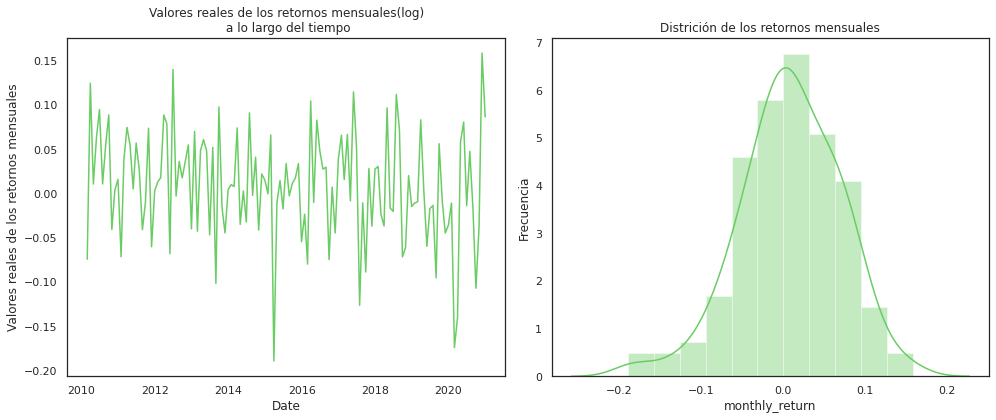

In [ ]:
# Dibujando el valor actual y la distribucion de retornos semanales. 
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.lineplot(monthly_data.index, monthly_data['monthly_return'], color="g")
plt.ylabel('Valores reales de los retornos mensuales')
plt.title('Valores reales de los retornos mensuales(log)\n a lo largo del tiempo')

plt.subplot(1,2,2)
sns.distplot(monthly_data['monthly_return'], kde=True, color="g")
plt.ylabel('Frecuencia')
plt.title('Districión de los retornos mensuales')

plt.tight_layout()
plt.show();

In [ ]:
from scipy.stats import shapiro
stat2, p2 = shapiro(monthly_data['monthly_return'])

if p2 < 0.01:
    test_result1 = 'No es Normal'
    print(f' Si el p-value es {p2}, por lo tanto se rechaza que los datos se distribuyen normnalmente con un 99% de confianza.')
else:
    test_result1 = 'NORMAL'
    print(f'El p-value es {p2}, por lo tanto asumimos que los datos estan distribuidos normalmente con un 99% de confianza. ')

El p-value es 0.27058279514312744, por lo tanto asumimos que los datos estan distribuidos normalmente con un 99% de confianza. 


<font color='green'>Fin actividad 1</font>

### 7. Intervalo de confianza

El __intervalo de confianza__ describe la variabilidad entre la medida obtenida en un estudio y la medida real de la población (el valor real). Corresponde a un rango de valores, cuya distribución es normal y en el cual se encuentra, con alta probabilidad, el valor real de una determinada variable. Esta _"alta probabilidad"_ se ha establecido por consenso en 95%. Así, un intervalo de confianza de 95% nos indica que dentro del rango dado se encuentra el valor real de un parámetro con 95% de certeza.

Volviendo al problema de inversión de Loki, como podemos asumir con seguridad que los rendimientos mensuales se distribuyen normalmente, podemos utilizar el concepto estadístico de intervalos de confianza para obtener un rango de rendimiento mensual promedio con cierta confianza.

En general, bajo el supuesto de normalidad, el intervalo de confianza viene dado por:

$$ \bar{x} \pm z *\frac{s}{\sqrt{n}}$$

Donde _z_ es el _z-score_ asociado con un nivel determinado de confianza.

Entonces, si queremos obtener el intervalo de confianza del 95% para el rendimiento mensual promedio, ya que casi el 95% de los datos para una variable normal estándar se encuentra entre aproximadamente +/- 2 desviaciones estándar, el puntaje _z_ sería 2 (1,96 para ser ¡preciso!).

Además, como no conocemos la desviación estándar de la población
σ, usaremos la desviación estándar de la muestra _s_ en su lugar.
En el siguiente código, calculamos el intervalo de confianza para el rendimiento mensual promedio:

In [ ]:
z = 1.96

mean = np.mean(monthly_data['monthly_return'])

std = np.std(monthly_data['monthly_return'],ddof=1)/ np.sqrt(len(monthly_data))

#95% Intervalo de confianza.
upper = mean + z * std
lower = mean - z * std


CI_95 = (100*np.round(lower,3),100*np.round(upper,3))
print(f'Estimación del rendimiento mensual medio: {100 * mean:4.3f}%') # Lo expresamos como por ciento
print(f'Intervalo de confianza del 95% para el rendimiento mensual medio en %: {CI_95}')


Estimación del rendimiento mensual medio: 0.868%
Intervalo de confianza del 95% para el rendimiento mensual medio en %: (-0.2, 1.9)
